# MCMC Sampling From Circular Posterior


My goal is to derive constraints on exoplanet eccentricity using a two-step approach

1. Fit a light curve assuming a circular orbit, letting {per, tc, r, b, rhocirc} float
2. Use the posterior on rhocirc to establish constraints on e, omega using the measured density of the star.

My thinking in doing this two-step approach is one can quickly fit the light curve which itself which just depends on the photometry. Then one can derive eccentricity constraints given different sources of mean-stellar density or priors on eccentricity.

### Imports and defining some functions 

In [2]:
%pylab inline
#%load_ext line_profiler
import exoplanet as xo
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from chainconsumer import ChainConsumer
import seaborn as sns
rcParams['figure.dpi'] = 160
def _tfold(t, per, tc):
    return np.mod(((t - tc) + 0.5 * per),per) -  0.5 * per

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.dpi'] = 160 # execute twice

### Generating a synthetic light curve

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of 

snr 45.41952590388118


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


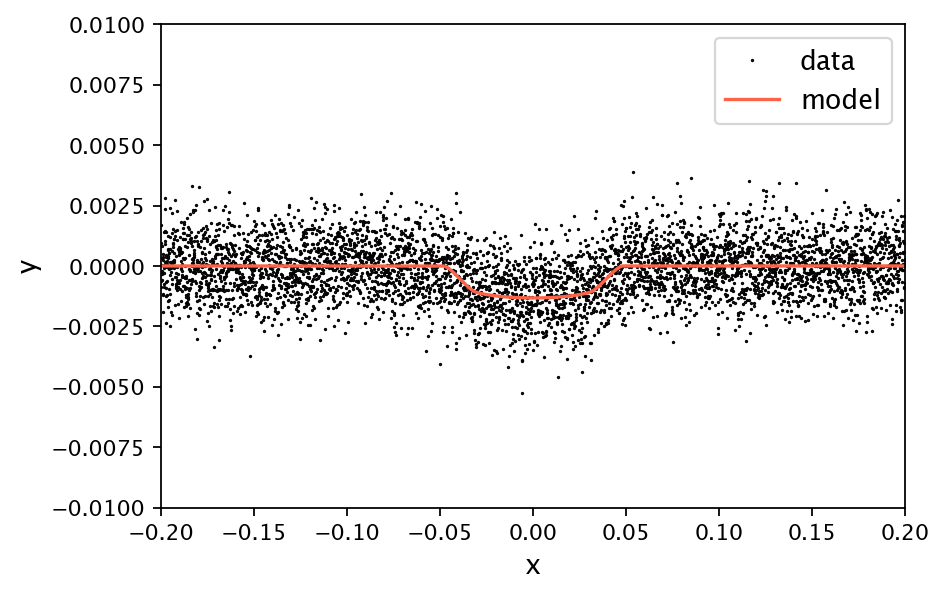

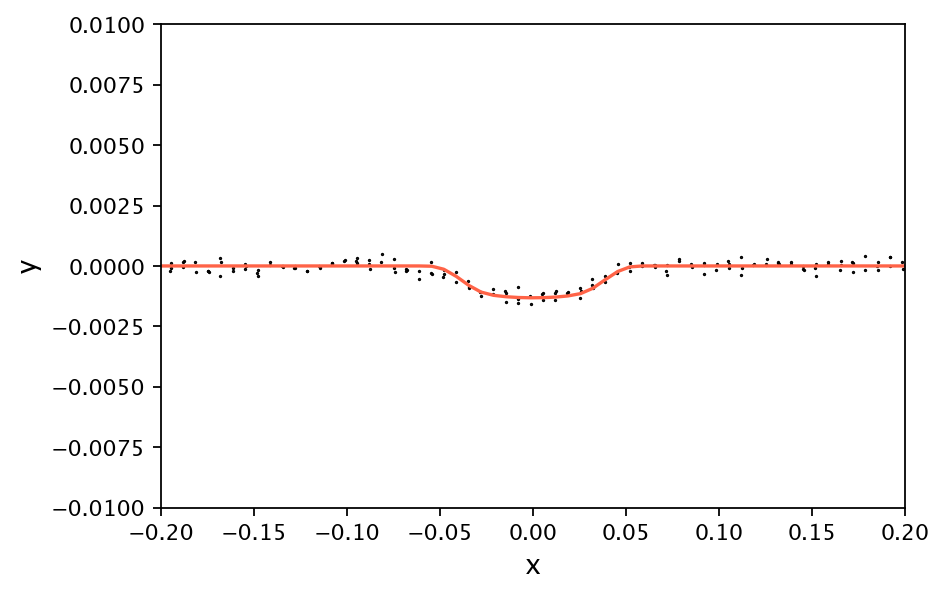

In [3]:
np.random.seed(42)
truth = dict(per=10.3134134, tc=5.124124, b=0.9, r=0.04, ecc=0.0, omega=90)
u = np.array([0.4451, 0.2297])
texp_lc = 0.02
texp_sc = texp_lc/30
yerr_lc = 2e-4
yerr_sc = yerr_lc*sqrt(texp_lc/texp_sc)


t = np.arange(0, 80, texp_sc)
orbit0 = xo.orbits.KeplerianOrbit(
    period=truth['per'], 
    t0=truth['tc'], 
    b=truth['b'], 
    ecc=truth['ecc'],
    omega=truth['omega'],
    rho_star = 1
)

lc_model = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit0, r=truth['r'], t=t,texp=None).eval()
lc_data = (lc_model + yerr_sc * np.random.randn(*lc_model.shape)).reshape(-1) # need this for single planet fit
tfold = _tfold(t, truth['per'],truth['tc'])
isort = argsort(tfold)

plt.plot(tfold[isort], lc_data[isort],'.',ms=1,color="k", label="data")
plt.plot(tfold[isort], lc_model[isort], "C1", label="model")
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.01, 0.01);


# Create long cadence light curve
figure()
lc_data_lc = lc_data.reshape(-1,30).mean(axis=1)
lc_model_lc = lc_model.reshape(-1,30).mean(axis=1)
t_lc = t.reshape(-1,30).mean(axis=1)
tfold_lc = _tfold(t_lc, truth['per'],truth['tc'])
isort_lc = argsort(tfold_lc)


plt.plot(tfold_lc[isort_lc], lc_data_lc[isort_lc],'.',ms=1,color="k", label="data")
plt.plot(tfold_lc[isort_lc], lc_model_lc[isort_lc], "C1", label="model")

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.01, 0.01);


print("snr {}".format(truth['r']**2 / yerr_sc * sqrt(len(orbit0.in_transit(t).eval()))))

## Long cadence

A note about the parameterization. I played around quite a bit with different ways to parameterize the light curve:

1. $\{b, R_p/R_\star, \log{\rho_{\star,circ}} \}$
2. $\{b, R_p/R_\star, \log{T_{14}} \}$
3. $\{b,  y, \log{T_{14}} \}$, where $y = (R_p/R_\star / \sqrt{d} - 1) \sqrt{1 - b^2}$ and d is the depth of the transit

I found that number 3 performed the best. More draws per second with a lower divergence rate. When using basis set 1 there is a strong curving degeneracy between all three parameters. Using $T_{14}$ in basis set 2 removes some of this curvature because it's more closely related to the observed duration of the transit (except at high impact parameters). But still, there is a strong curving degeneracy between $Rp/Rstar$ and $b$, due to the trade off between impact parameter and the stellar surface brightness along the transit chord. It seems silly to force the mcmc algorithm to "rediscover" this relationship on its own and divide it out. Dividing by the measured transit duration "standardizes" the data. 

In [4]:
grav = 498.2174 # G in cm**3 / g / d**2
with pm.Model() as model_lc:
    # Setup light curve
    mean = pm.Normal("mean", mu=0.0, sd=0.1,testval=0.0)
    b = pm.Uniform("b", lower=0.0,upper=1.0)
    y = pm.Uniform("y", lower=-1, upper=1, testval=0.05)
    r = pm.Deterministic("r", 0.032* (y / tt.sqrt(1-b**2) + 1  )  )
    logT14 = pm.Uniform("logT14", lower=-2, upper=0, testval=-1) # duration in log days
    T14 = pm.Deterministic("T14", 10**logT14)
    a = truth['per'] / pi * tt.sqrt( (1+r)**2 - b**2 ) / T14
    rho = pm.Deterministic("rho", 3 * np.pi / grav / truth['per']**2 * a**3)
    
    # Compute light curve
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, a=a)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Compute likelihood
    pm.Normal("obs", mu=light_curve, sd=yerr_lc, observed=lc_data_lc)
    map_soln = xo.optimize(start=model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)
    
print(map_soln)

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [y, b]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
25it [00:00, 152.99it/s, logp=2.836054e+04]
message: Optimization terminated successfully.
logp: 28338.738678509166 

{'mean': array(1.99931869e-06), 'b_interval__': array(2.50837893), 'y_interval__': array(0.19572847), 'logT14_interval__': array(0.0136158), 'b': array(0.92472713), 'y': array(0.097553), 'r': array(0.04020138), 'logT14': array(-0.99319221), 'T14': array(0.1015799), 'rho': array(0.64882788)}



message: Desired error not necessarily achieved due to precision loss.
logp: 28360.53707231992 -> 28360.74784959906


In [5]:
tune=2000
draws=5000
adaptation_window=101
target_accept=0.99
doubling=False
with model_lc:
    tr_lc = pm.sample(
        start=map_soln,
        step=xo.get_dense_nuts_step(start=map_soln,target_accept=target_accept,doubling=doubling),
        tune=tune,
        draws=draws
    )

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logT14, y, b, mean]
Sampling 4 chains: 100%|██████████| 28000/28000 [05:09<00:00, 90.46draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


         mean     sd  mc_error  hpd_2.5  hpd_97.5     n_eff  Rhat
mean    0.000  0.000     0.000   -0.000     0.000  9522.668   1.0
b       0.499  0.290     0.006    0.037     0.966  2473.151   1.0
y       0.034  0.041     0.001   -0.033     0.109  2650.914   1.0
r       0.034  0.004     0.000    0.030     0.042  2271.760   1.0
logT14 -1.052  0.033     0.001   -1.099    -0.970  2467.814   1.0
T14     0.089  0.007     0.000    0.079     0.106  2417.224   1.0
rho     6.648  3.832     0.072    0.193    11.941  2671.052   1.0


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


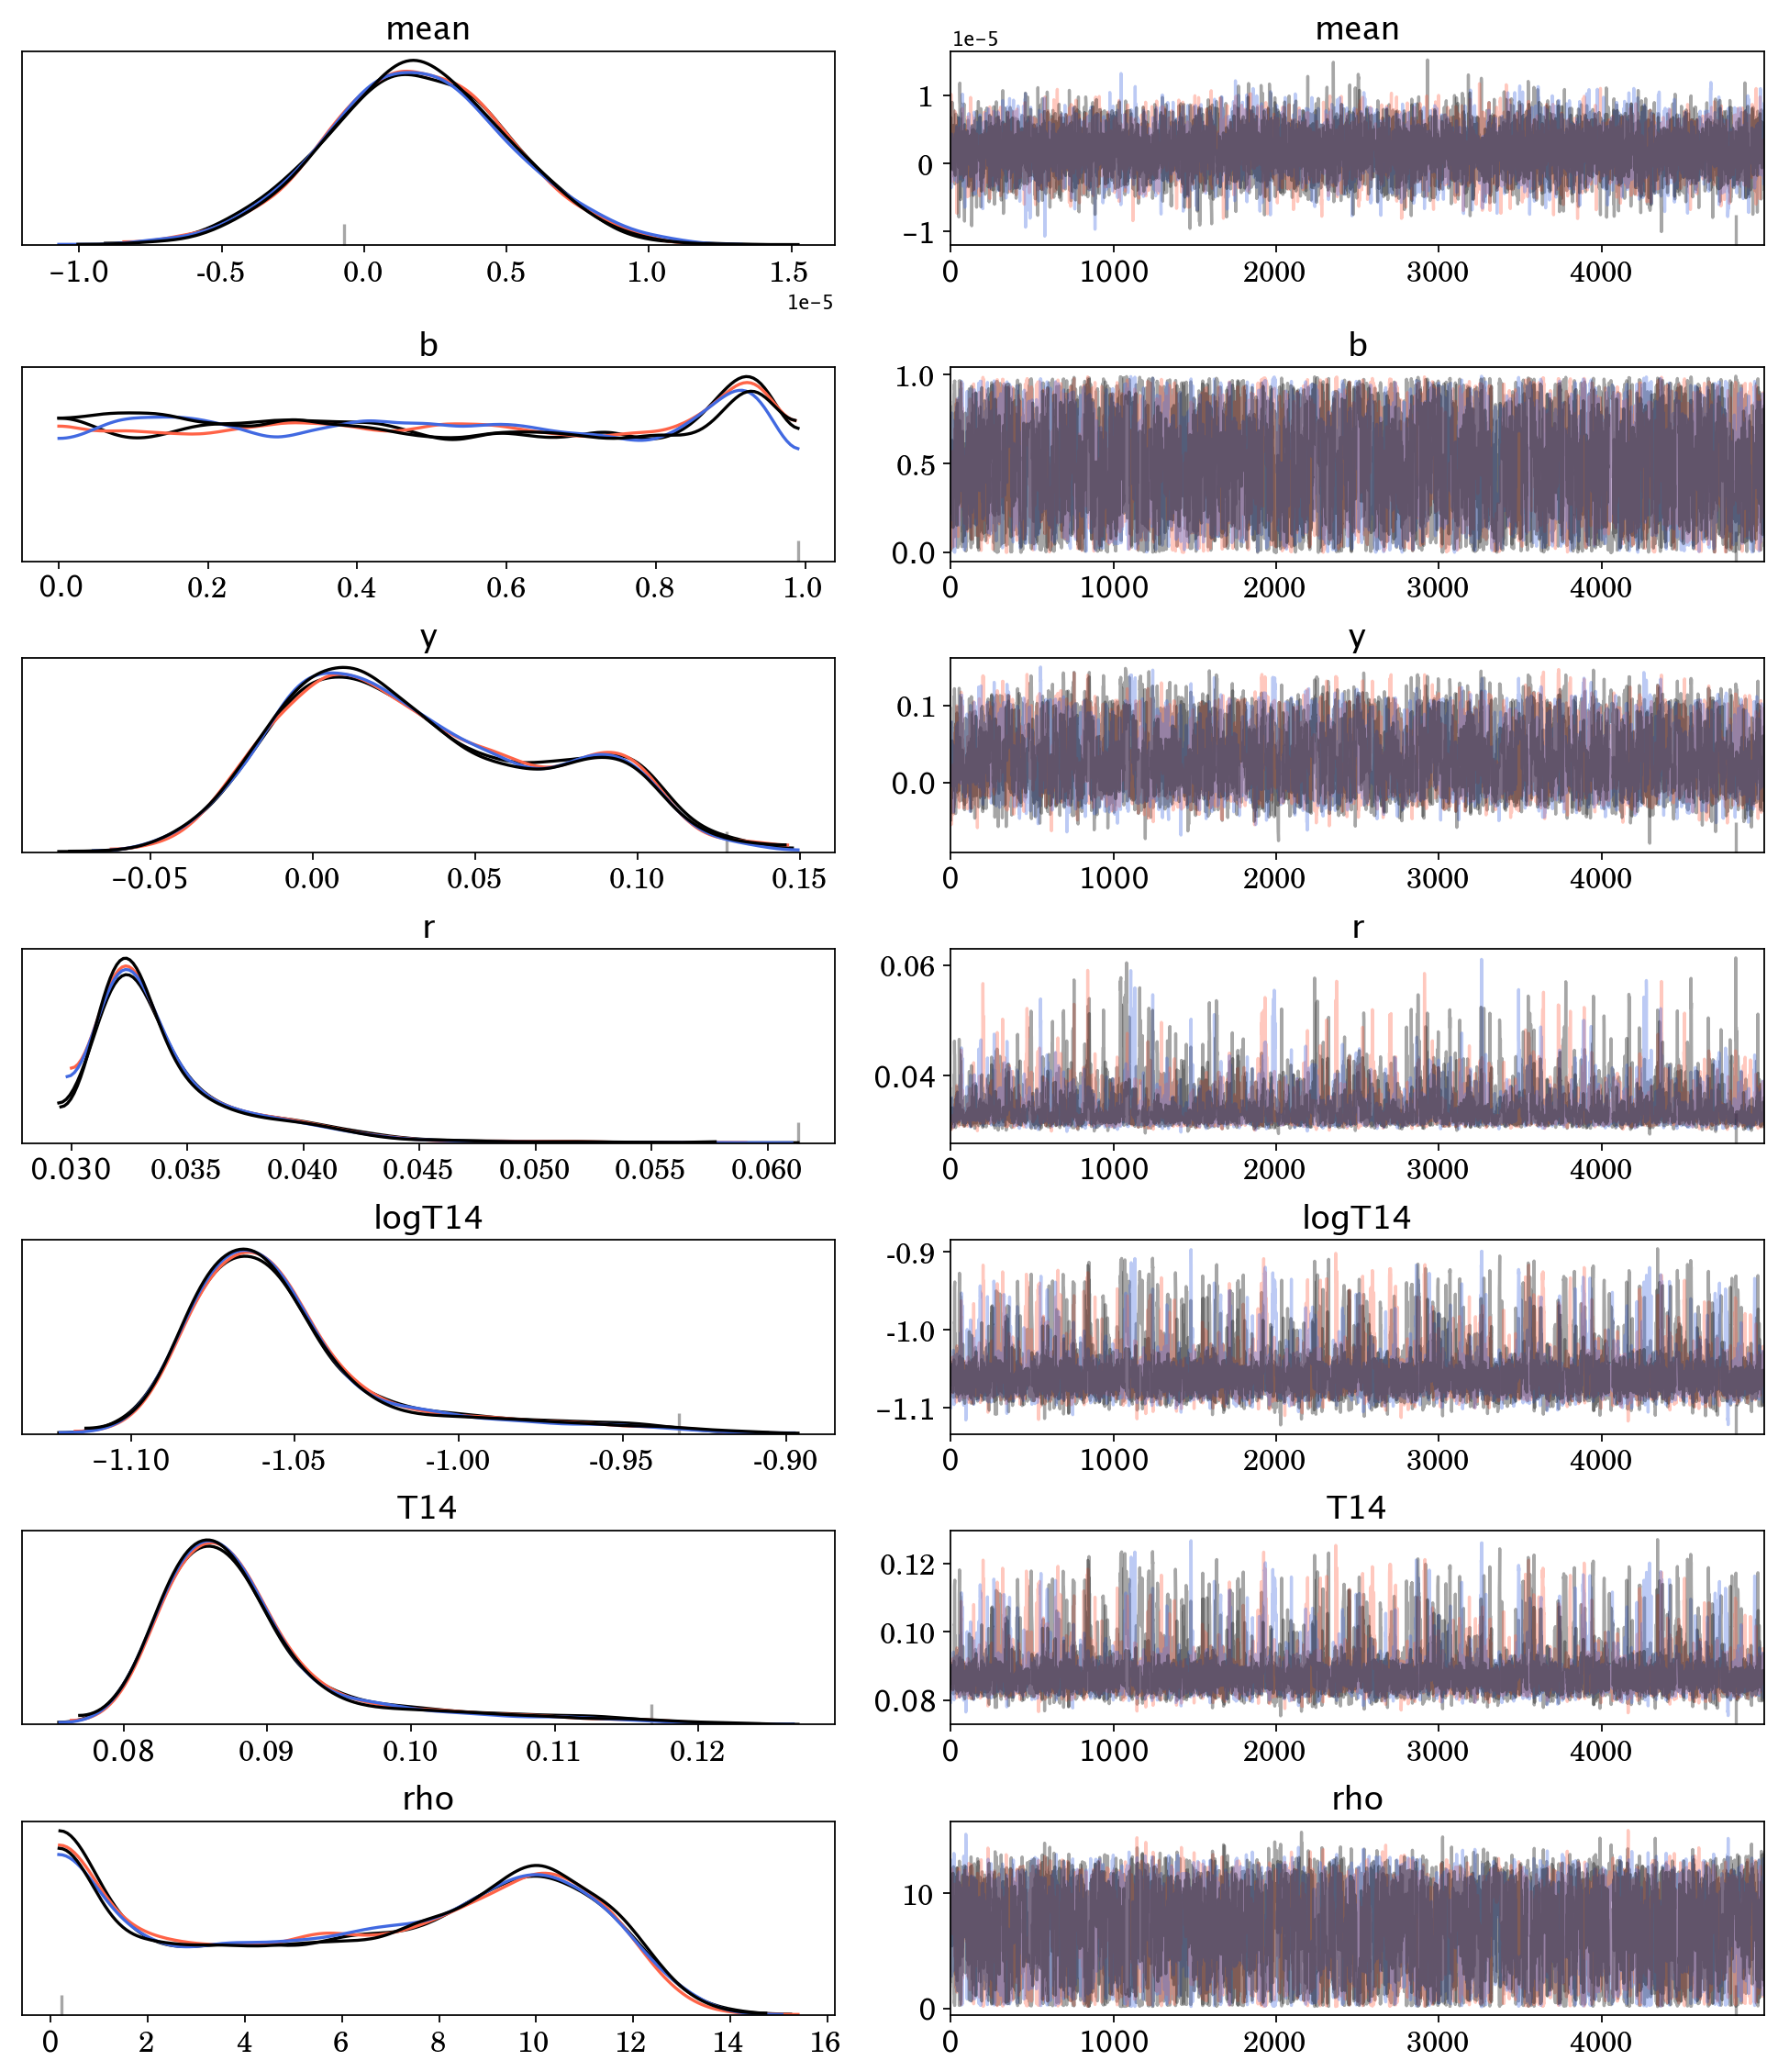

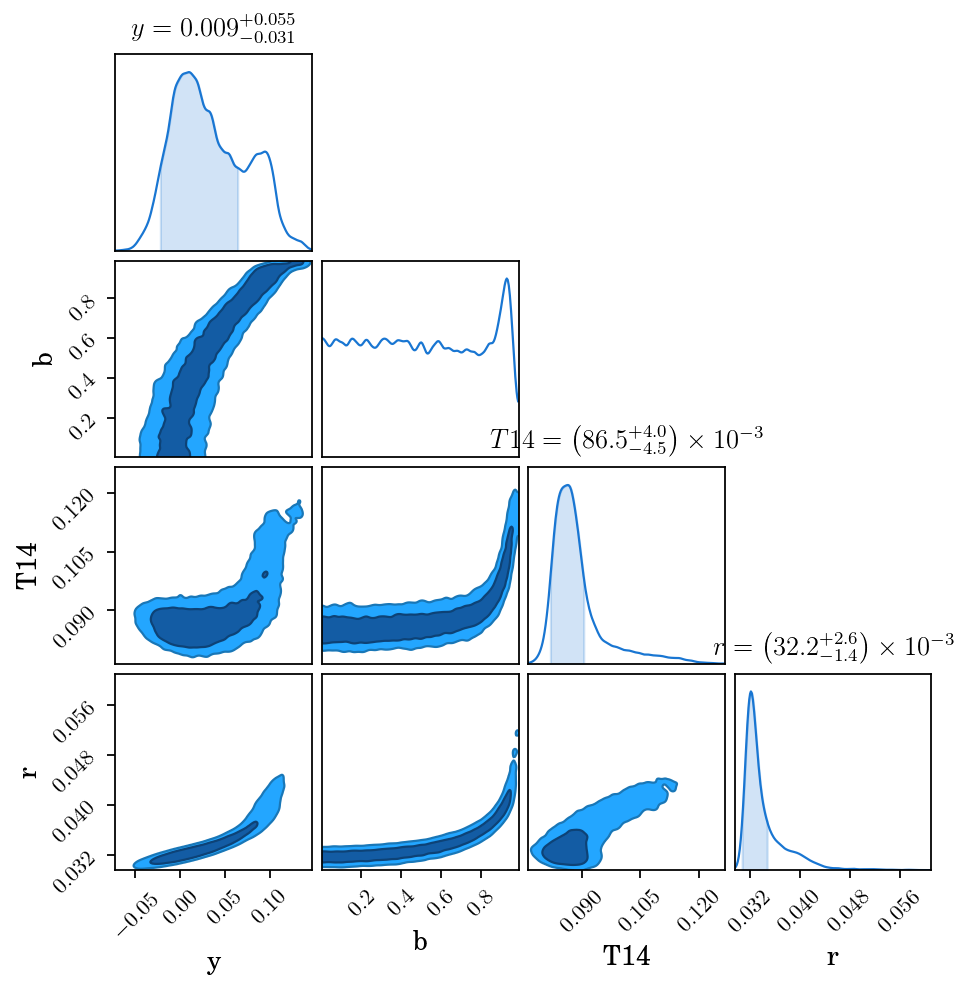

In [6]:
df = pm.trace_to_dataframe(tr_lc)
df.to_csv('chain_lc-y-T14-99.csv')
print( pm.summary(tr_lc).round(3) ) 
pm.traceplot(tr_lc)
df = pm.trace_to_dataframe(tr_lc)
varnames='y b T14 r'.split()
c = ChainConsumer()
c.add_chain(array(df[varnames]),parameters=varnames)
fig = c.plotter.plot()

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(-0.002, 0.001)

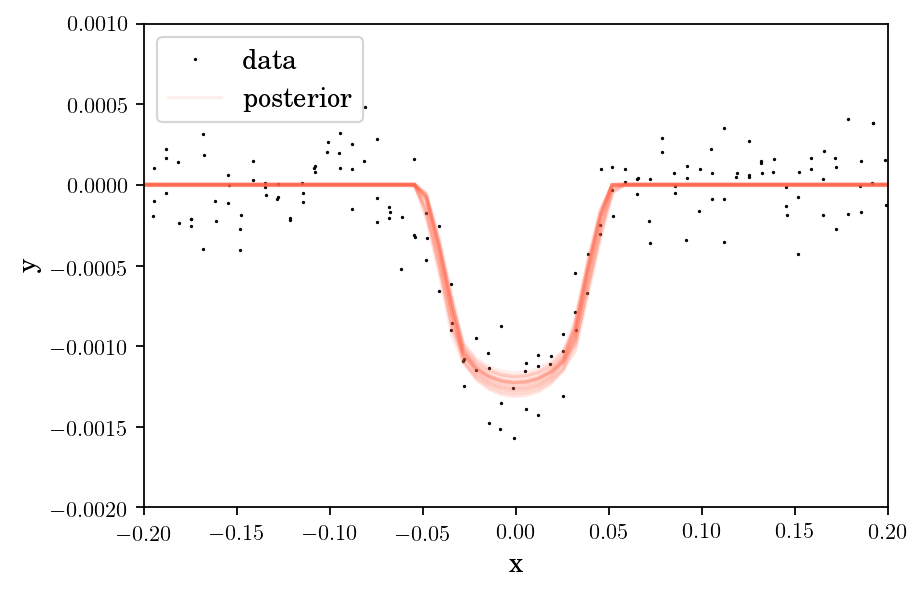

In [7]:
tfold = _tfold(t_lc, truth['per'],truth['tc'])
x_grid = t_lc
nsamples= 25
samples = np.empty((nsamples, len(x_grid)))
with model_lc:
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    y_grid = light_curve
    for i, sample in enumerate(xo.get_samples_from_trace(tr_lc, size=nsamples)):
        samples[i] = xo.eval_in_model(y_grid, sample)
        
isort = argsort(tfold_lc)
plt.plot(tfold_lc[isort], lc_data_lc[isort], ".k",ms=1, label="data")
plt.plot(tfold_lc[isort], samples[0,isort],color="C1", alpha=0.1, label="posterior")
plt.plot(tfold_lc[isort], samples[1:,isort].T,color="C1", alpha=0.1)
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.002,0.001)

## Short Cadence

In [8]:
grav = 498.2174 # G in cm**3 / g / d**2
with pm.Model() as model_sc:
    mean = pm.Normal("mean", mu=0.0, sd=0.1,testval=0.0)
    b = pm.Uniform("b", lower=0.0,upper=1.0)
    y = pm.Uniform("y", lower=-1, upper=1, testval=0.05)
    r = pm.Deterministic("r", 0.032* (y / tt.sqrt(1-b**2) + 1  )  )
    logT14 = pm.Uniform("logT14", lower=-2, upper=0, testval=-1) # duration in log days
    T14 = pm.Deterministic("T14", 10**logT14)
    a = truth['per'] / pi * tt.sqrt( (1+r)**2 - b**2 ) / T14
    rho = pm.Deterministic("rho", 3 * np.pi / grav / truth['per']**2 * a**3)

    # Compute light curve
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, a=a)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t, texp=None) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Compute likelihood
    pm.Normal("obs", mu=light_curve, sd=yerr_sc, observed=lc_data)
    map_soln = xo.optimize(start=model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)
    
print(map_soln)

optimizing logp for variables: [y, b]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
23it [00:00, 120.73it/s, logp=6.476107e+05] 
message: Optimization terminated successfully.
logp: 647576.6809692298 -> 647610.7387842305
optimizing logp for variables: [logT14, y, b, mean]
71it [00:00, 236.19it/s, logp=6.476111e+05]/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

{'mean': array(2.1249455e-06), 'b_interval__': array(2.56667644), 'y_interval__': array(0.20352827), 'logT14_interval__': array(0.02211241), 'b': array(0.9286859), 'y': array(0.1014143), 'r': array(0.04075046), 'logT14': array(-0.98894425), 'T14': array(0.10257836), 'rho': array(0.60443994)}


In [9]:
tune=2000
draws=5000
adaptation_window=101
target_accept=0.99
doubling=False
with model_sc:
    tr_sc = pm.sample(
        start=map_soln,
        step=xo.get_dense_nuts_step(start=map_soln,target_accept=target_accept,doubling=doubling),
        tune=tune,
        draws=draws
    )

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logT14, y, b, mean]
INFO:pymc3:NUTS: [logT14, y, b, mean]
Sampling 4 chains: 100%|██████████| 28000/28000 [39:57<00:00, 11.68draws/s]   
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameteriz

In [ ]:
import pickle
import arviz
arviz.plot_trace(tr_sc,var_names=['y'])

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


         mean     sd  mc_error  hpd_2.5  hpd_97.5      n_eff   Rhat
mean    0.000  0.000     0.000   -0.000     0.000  11450.136  1.000
b       0.804  0.245     0.009    0.160     0.993    566.578  1.004
y       0.084  0.037     0.001   -0.008     0.126    647.244  1.004
r       0.039  0.004     0.000    0.031     0.044    766.459  1.004
logT14 -1.012  0.038     0.001   -1.084    -0.957    875.561  1.003
T14     0.098  0.008     0.000    0.082     0.110    913.034  1.003
rho     2.404  3.375     0.127    0.199    10.895    579.051  1.004


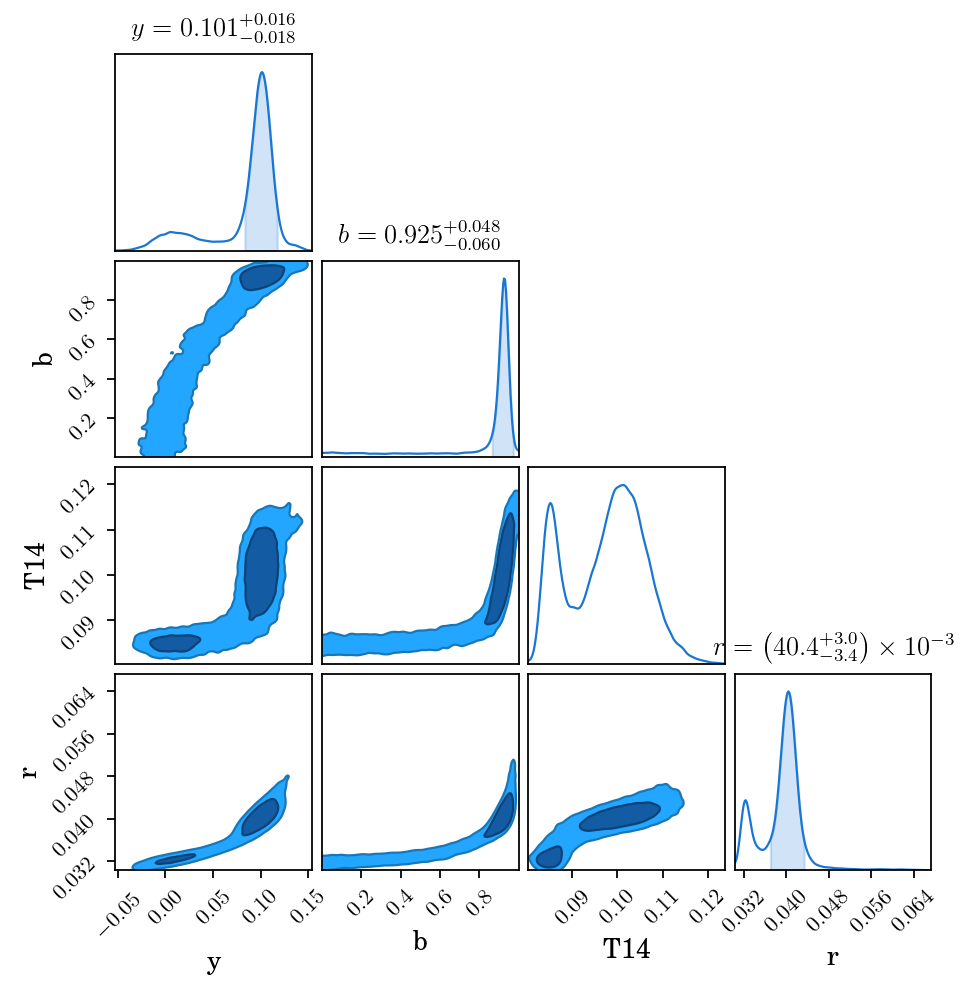

In [23]:
df = pm.trace_to_dataframe(tr_sc)
df.to_csv('chain_sc-y-T14-99.csv')
print( pm.summary(tr_sc).round(3) ) 
varnames='y b T14 r'.split()
#pm.traceplot(tr_sc,varnames=varnames)
c = ChainConsumer()
c.add_chain(array(df[varnames]),parameters=varnames)
fig = c.plotter.plot()

(-0.002, 0.001)

/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/petigura/anaconda2/envs/keprat/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


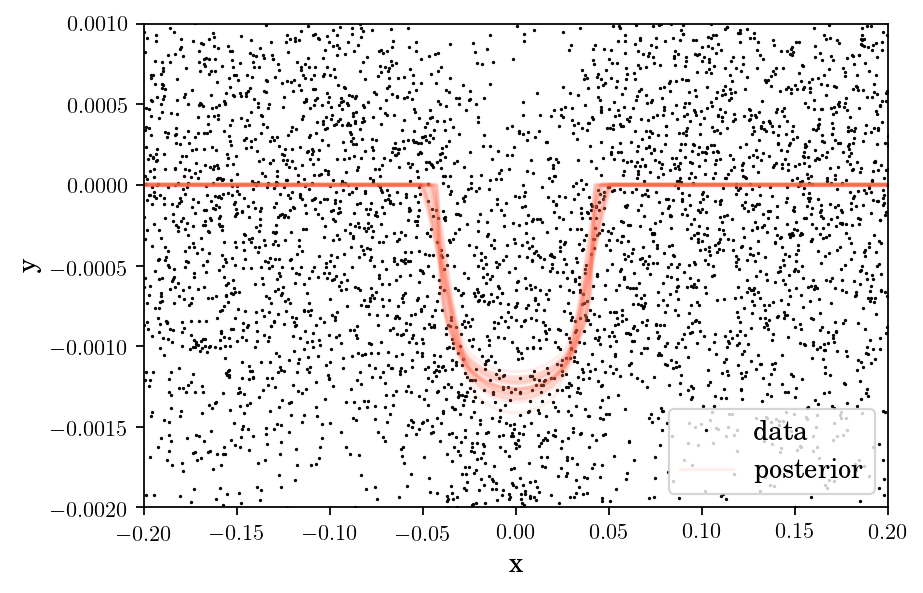

In [33]:
tfold = _tfold(t, truth['per'],truth['tc'])
x_grid = t
nsamples= 25
samples = np.empty((nsamples, len(x_grid)))
with model_sc:
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t, texp=None) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    y_grid = light_curve
    for i, sample in enumerate(xo.get_samples_from_trace(tr_sc, size=nsamples)):
        samples[i] = xo.eval_in_model(y_grid, sample)
        
isort = argsort(tfold)
plt.plot(tfold[isort], lc_data[isort], ".k",ms=1, label="data")
plt.plot(tfold[isort], samples[0,isort],color="C1", alpha=0.1, label="posterior")
plt.plot(tfold[isort], samples[1:,isort].T,color="C1", alpha=0.1)
plt.legend(fontsize=12)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.2, 0.2);
plt.ylim(-0.002,0.001)

## Use importance sampling to derive posteriors

- Assume we have measured mean stellar density to 12\% fractional precision, which is possible given Gaia parallaxes
- Apply various priors on eccentricity
  - Uniform $\mathcal{U}(0,0.99)$
  - Van Eylen+19 distribution for singles $\mathcal{N}^{+}(0,0.3)$
  - Van Eylen+19 distribution for multis $\mathcal{N}^{+}(0,0.08)$
 
- I have not yet implemented a transit prior, which depends on a/Rstar and ecc
- I have not yet implemented a minimum periastron prior

In [34]:
def importance_sampling(chain, logrho_obs, fupsample=10, eccprior='uniform'):
    """
    Compute weights (importance sampling) based on difference measured rhostar and eccentricity priors
    """

    rho = chain["rho"]
    logrho_circ = np.log10(rho)
    logrho_circ = np.hstack([logrho_circ ]*fupsample)
    r = np.hstack([chain["r"]]*fupsample)
    b = np.hstack([chain["b"]]*fupsample)

    if eccprior=='uniform':
        ecc = np.random.uniform(0, 0.99, len(logrho_circ))
    elif eccprior=='v19-single':
        ecc = abs((randn(len(logrho_circ)) * 0.3 ))
        eccmax = np.ones_like(ecc) * 0.99
        ecc = np.min(vstack([ecc,eccmax]),axis=0)
    elif eccprior=='v19-multi':
        ecc = abs((randn(len(logrho_circ)) * 0.08 ))
        eccmax = np.ones_like(ecc) * 0.99
        ecc = np.min(vstack([ecc,eccmax]),axis=0)
    else:
        assert False, "prior not implemented"

    omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(logrho_circ))
    omega_deg = np.rad2deg(omega)

    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    logrho = logrho_circ - log10(g**3) 
    log_weight = -0.5 * ((logrho - logrho_obs[0]) / logrho_obs[1]) ** 2
    weight = np.exp(log_weight - np.max(log_weight))
    chain2 = pd.DataFrame(dict(r=r,b=b,ecc=ecc,logrho_circ=logrho_circ,omega=omega,omega_deg=omega_deg, weight=weight))
    return chain2


###  Eccentricity:  $\mathcal{U}(0,0.99)$

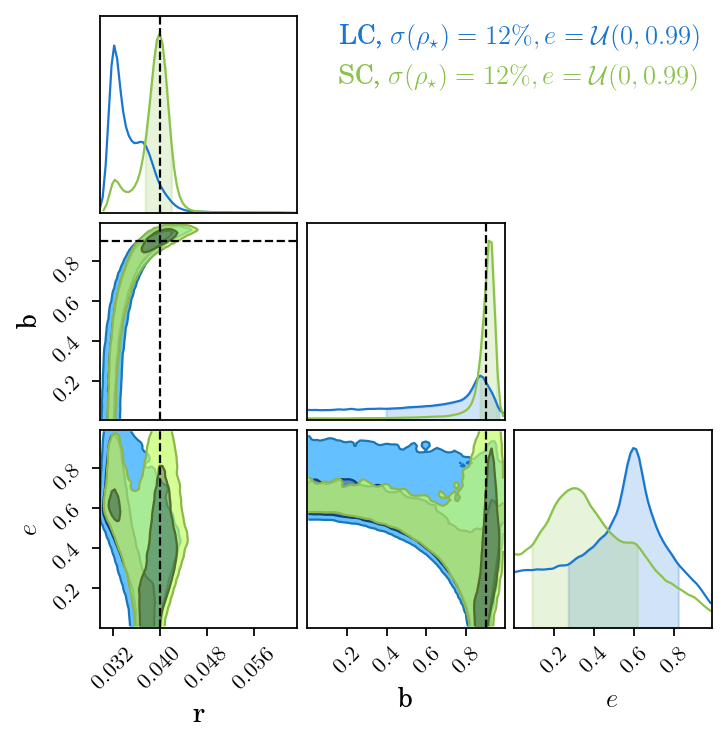

In [35]:
logrho_obs = (log10(1.4),0.05)  # for example
fupsample = 10 # duplicate chains by this amount
columns = 'r b ecc'.split()
parameters=[r'r','b',r'$e$']
name = r'$\sigma(\rho_\star) = 12\%, e = \mathcal{U}(0,0.99)$'
eccprior='uniform'

c = ChainConsumer()
dflc = pd.read_csv('test-lc-y-T14-95.csv',index_col=0)
chain = importance_sampling(dflc, logrho_obs, fupsample=fupsample,eccprior=eccprior)
chain_sorted = chain.sort_values(by='weight')
chain = chain_sorted[(chain_sorted.weight.cumsum() / chain_sorted.weight.sum()) > 1e-4]
c.add_chain(array(chain[columns]), weights=array(chain.weight),parameters=parameters, name = 'LC, '+name)

dfsc = pd.read_csv('test-sc-y-T14-95.csv',index_col=0)
chain = importance_sampling(dfsc, logrho_obs, fupsample=fupsample,eccprior=eccprior)
chain_sorted = chain.sort_values(by='weight')
chain = chain_sorted[(chain_sorted.weight.cumsum() / chain_sorted.weight.sum()) > 1e-4]
c.add_chain(array(chain[columns]), weights=array(chain.weight),parameters=parameters, name='SC, '+name)

c.configure(smooth=True)
fig = c.plotter.plot(truth=truth)

### Van Eylen+19 distribution for singles $\mathcal{N}^{+}(0,0.3)$
The Rp/Rstar posterior moves closer to its true value

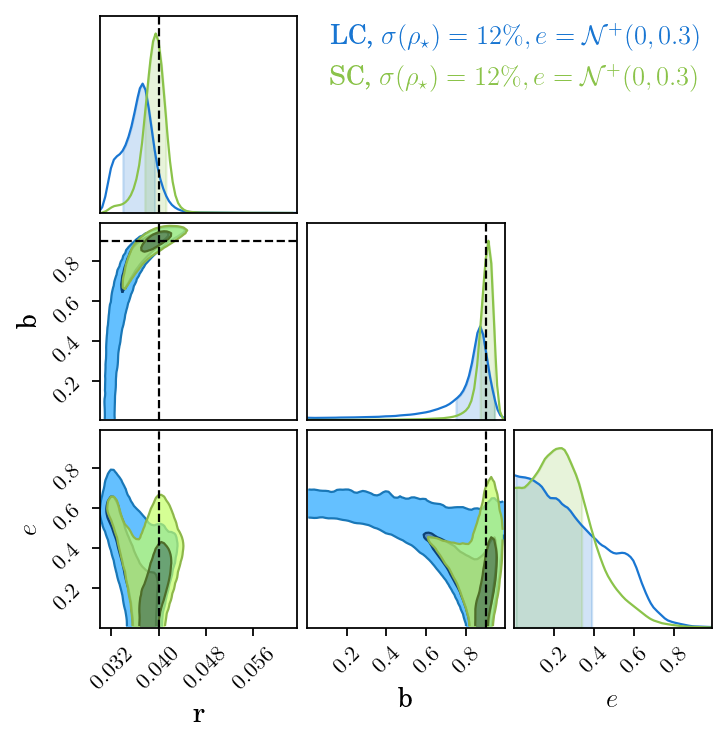

In [36]:
logrho_obs = (log10(1.4),0.05)  # for example
fupsample = 10 # duplicate chains by this amount
columns = 'r b ecc'.split()
parameters=[r'r','b',r'$e$']
name = r'$\sigma(\rho_\star) = 12\%, e = \mathcal{N^+}(0,0.3)$'
eccprior='v19-single'

c = ChainConsumer()
dflc = pd.read_csv('test-lc-y-T14-95.csv',index_col=0)
chain = importance_sampling(dflc, logrho_obs, fupsample=fupsample,eccprior=eccprior)
chain_sorted = chain.sort_values(by='weight')
chain = chain_sorted[(chain_sorted.weight.cumsum() / chain_sorted.weight.sum()) > 1e-4]
c.add_chain(array(chain[columns]), weights=array(chain.weight),parameters=parameters, name = 'LC, '+name)

dfsc = pd.read_csv('test-sc-y-T14-95.csv',index_col=0)
chain = importance_sampling(dfsc, logrho_obs, fupsample=fupsample,eccprior=eccprior)
chain_sorted = chain.sort_values(by='weight')
chain = chain_sorted[(chain_sorted.weight.cumsum() / chain_sorted.weight.sum()) > 1e-4]
c.add_chain(array(chain[columns]), weights=array(chain.weight),parameters=parameters, name='SC, '+name)

c.configure(smooth=True)
fig = c.plotter.plot(truth=truth)

### Van Eylen+19 distribution for multis $\mathcal{N}^{+}(0,0.08)$

The Rp/Rstar posterior moves closer to its true value

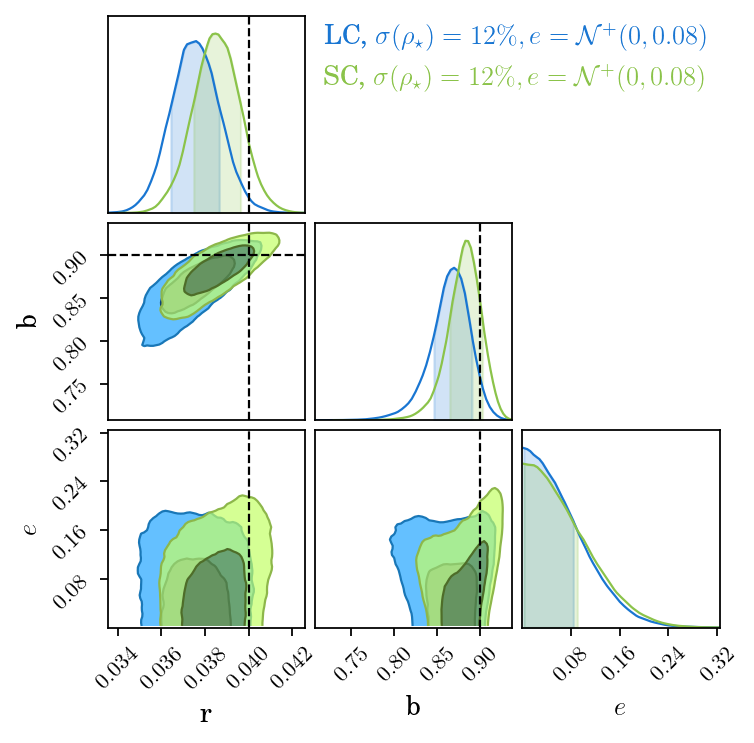

In [37]:
logrho_obs = (log10(1.4),0.05)  # for example
fupsample = 10 # duplicate chains by this amount
columns = 'r b ecc'.split()
parameters=[r'r','b',r'$e$']
name = r'$\sigma(\rho_\star) = 12\%, e = \mathcal{N^+}(0,0.08)$'
eccprior='v19-multi'

c = ChainConsumer()
dflc = pd.read_csv('test-lc-y-T14-95.csv',index_col=0)
chain = importance_sampling(dflc, logrho_obs, fupsample=fupsample,eccprior=eccprior)
chain_sorted = chain.sort_values(by='weight')
chain = chain_sorted[(chain_sorted.weight.cumsum() / chain_sorted.weight.sum()) > 1e-4]
c.add_chain(array(chain[columns]), weights=array(chain.weight),parameters=parameters, name = 'LC, '+name)

dfsc = pd.read_csv('test-sc-y-T14-95.csv',index_col=0)
chain = importance_sampling(dfsc, logrho_obs, fupsample=fupsample,eccprior=eccprior)
chain_sorted = chain.sort_values(by='weight')
chain = chain_sorted[(chain_sorted.weight.cumsum() / chain_sorted.weight.sum()) > 1e-4]
c.add_chain(array(chain[columns]), weights=array(chain.weight),parameters=parameters, name='SC, '+name)

c.configure(smooth=True)
fig = c.plotter.plot(truth=truth)